In [1]:
#!pip install --upgrade numpy


In [2]:
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.linalg import cholesky
import matplotlib.pyplot as plt
from scipy.linalg import eig
from scipy.stats import invwishart, percentileofscore

import time

In [3]:
def IWPQ(v, ixpx):
    k = ixpx.shape[0]
    z = np.zeros((v, k))
    mu = np.zeros((k, 1))

    for i in range(1,v):
        chol_ixpx = cholesky(ixpx,lower=False)#,lower=False)  #, lower=True)
        z[i, :] = (chol_ixpx.T @ np.random.randn(k, 1)).T

    out = np.linalg.inv(z.T @ z)
    return out

In [4]:
# PARAMETROS
Reps = 40000 #000
burn = 30000 #000

In [5]:
data = pd.read_excel('DATA/dataUS.xls', header=None)


In [7]:
data = pd.read_excel('DATA/dataUS.xls', header=None)
data = data.values
N = data.shape[1]
L = 2
Y = data.copy()
X = np.concatenate([np.ones((Y.shape[0], 1)), np.roll(Y, 1, axis=0), np.roll(Y, 2, axis=0)], axis=1)
Y = Y[2:, :]
X = X[2:, :]
T = X.shape[0]
data

array([[ 5.25857143,  4.83      ,  4.6       ,  2.07274692],
       [ 5.26684211,  4.56      ,  4.5       ,  2.40710431],
       [ 5.26090909,  4.65      ,  4.4       ,  2.77145329],
       [ 5.24333333,  4.63      ,  4.5       ,  2.63642443],
       [ 5.24954545,  4.9       ,  4.4       ,  2.67009126],
       [ 5.25380952,  5.03      ,  4.6       ,  2.59216375],
       [ 5.26285714,  4.78      ,  4.6       ,  2.3145539 ],
       [ 5.03521739,  4.54      ,  4.6       ,  1.93067734],
       [ 4.96631579,  4.59      ,  4.7       ,  2.72401828],
       [ 4.74863636,  4.48      ,  4.7       ,  3.54063654],
       [ 4.4965    ,  3.97      ,  4.7       ,  4.23574488],
       [ 4.219     ,  4.04      ,  5.        ,  4.02144245],
       [ 3.93142857,  3.67      ,  5.        ,  4.26102183],
       [ 2.9625    ,  3.53      ,  4.8       ,  4.05129258],
       [ 2.60285714,  3.45      ,  5.1       ,  3.93074442],
       [ 2.26772727,  3.77      ,  5.        ,  3.87940996],
       [ 1.99333333,  4.

In [6]:
# Compute standard deviation of each series residual via an OLS regression
# First variable
y1 = Y[:, 0]
x1 = X[:, 0:2]
# Compute the OLS coefficients for the first variable
b0 = np.linalg.inv(x1.T @ x1) @ (x1.T @ y1)
# Calculate residuals for the first variable
residuals1 = y1 - x1 @ b0
# Calculate the standard deviation of residuals for the first variable
s1 = np.sqrt((residuals1.T @ residuals1) / (y1.shape[0] - 2))
    
# Second variable
y2 = Y[:, 1]
x2 = X[:, [0, 2]]
b0 = np.linalg.inv(x2.T @ x2) @ (x2.T @ y2)
residuals2 = y2 - x2 @ b0
s2 = np.sqrt((residuals2.T @ residuals2) / (y2.shape[0] - 2))

# Third variable
y3 = Y[:, 2]
x3 = X[:, [0, 3]]
b0 = np.linalg.inv(x3.T @ x3) @ (x3.T @ y3)
residuals3 = y3 - x3 @ b0
s3 = np.sqrt((residuals3.T @ residuals3) / (y3.shape[0] - 2))

# Fourth variable
y4 = Y[:, 3]
x4 = X[:, [0, 4]]
b0 = np.linalg.inv(x4.T @ x4) @ (x4.T @ y4)
residuals4 = y4 - x4 @ b0
s4 = np.sqrt((residuals4.T @ residuals4) / (y4.shape[0] - 2))
    
    
    
# Parameters to control the prior
lamda1 = 0.1
lamda3 = 0.05
lamda4 = 1

In [7]:
# Specify the prior mean of the coefficients of the VAR
B0 = np.zeros((N * L + 1, N))
for i in range(N):
    B0[i + 1, i] = 0.95
    
B0 = B0.T.flatten()

In [8]:
# Specify the prior variance of vec(B)
H = np.eye(N * (N * L + 1))   

diagH = [2, 3, 4, 6, 7, 8, 9]  # Specify the diagonal elements to set to 1e-9
for i in diagH:
    H[i, i] = 1e-9
    
# First equation
H[0, 0] = (s1 * lamda4) ** 2
H[1, 1] = (lamda1) ** 2
H[5, 5] = (lamda1 / (2 ** lamda3)) ** 2

# second equation
H[9, 9] = (s2 * lamda4) ** 2
H[10, 10] = ((s2 * lamda1) / s1) ** 2
H[11, 11] = (lamda1) ** 2
H[12, 12] = ((s2 * lamda1) / s3) ** 2
H[13, 13] = ((s2 * lamda1) / s4) ** 2
H[14, 14] = ((s2 * lamda1) / (s1 * (2 ** lamda3))) ** 2
H[15, 15] = ((lamda1) / (2 ** lamda3)) ** 2
H[16, 16] = ((s2 * lamda1) / (s3 * (2 ** lamda3))) ** 2
H[17, 17] = ((s2 * lamda1) / (s4 * (2 ** lamda3))) ** 2

# third equation
H[18, 18] = (s3 * lamda4) ** 2
H[19, 19] = ((s3 * lamda1) / s1) ** 2
H[20, 20] = ((s3 * lamda1) / s2) ** 2
H[21, 21] = (lamda1) ** 2
H[22, 22] = ((s3 * lamda1) / s4) ** 2
H[23, 23] = ((s3 * lamda1) / (s1 * (2 ** lamda3))) ** 2
H[24, 24] = ((s3 * lamda1) / (s2 * (2 ** lamda3))) ** 2
H[25, 25] = ((lamda1) / (2 ** lamda3)) ** 2
H[26, 26] = ((s3 * lamda1) / (s4 * (2 ** lamda3))) ** 2

# fourth equation
H[27, 27] = (s4 * lamda4) ** 2
H[28, 28] = ((s4 * lamda1) / s1) ** 2
H[29, 29] = ((s4 * lamda1) / s2) ** 2
H[30, 30] = ((s4 * lamda1) / s3) ** 2
H[31, 31] = (lamda1) ** 2
H[32, 32] = ((s4 * lamda1) / (s1 * (2 ** lamda3))) ** 2
H[33, 33] = ((s4 * lamda1) / (s2 * (2 ** lamda3))) ** 2
H[34, 34] = ((s4 * lamda1) / (s3 * (2 ** lamda3))) ** 2
H[35, 35] = ((lamda1) / (2 ** lamda3)) ** 2

In [9]:
def vec(y):
    x = []
    for i in range(y.shape[1]):  # Assuming y is a 2D NumPy array
        x.extend(y[:, i])
    return np.array(x)



In [10]:
# Prior scale matrix for Sigma, the VAR covariance
S = np.eye(N)

# Prior degrees of freedom
alpha = N + 1

# Starting values for the Gibbs sampling algorithm
Sigma = np.eye(N)
betaols = vec(np.linalg.inv(X.T @ X)@ (X.T @ Y))  #36*1

betaols

array([ 1.14400833e-01,  1.41542602e+00,  6.80106605e-02, -1.20212233e-01,
       -3.14743662e-02, -4.72372046e-01,  7.13626219e-03,  8.66078794e-02,
       -1.45657801e-02,  2.69871777e+00,  6.39772749e-01,  7.39965723e-01,
       -5.83839962e-01,  6.47777434e-02, -7.04792187e-01, -6.09292638e-02,
        4.16534115e-01, -1.11593290e-01,  2.06558246e+00, -1.28231755e-01,
        7.42342080e-02,  5.98160020e-01, -6.11786524e-02, -8.18425922e-02,
       -3.51898343e-02,  1.88158348e-01,  3.18157108e-04,  1.93189093e+00,
        2.23313216e-01, -3.83126745e-01, -5.12201068e-01,  1.50315189e+00,
       -2.60906238e-01,  2.80055535e-01,  3.63109005e-01, -6.81173223e-01])

In [11]:
def stability(beta, n, l):
    
    coef = (beta.reshape(n,n * L + 1)).T
    
    FF = np.zeros((n*l, n*l))

    temp = (beta.reshape(n,n * L + 1)).T
    
    temp = coef[1:n*l, :n-1].T
    
    FF[:n-1, :n*l-1] = temp
    
    ee = np.max(np.abs(np.linalg.eigvals(FF)))

    S = ee > 1
    
    return S

In [12]:
M1 = np.linalg.inv(H) + np.kron(np.linalg.inv(Sigma), X.T @ X)
M2 = np.linalg.inv(H) @ B0 + np.kron(np.linalg.inv(Sigma), X.T @ X) @ betaols
M = np.linalg.inv(M1) @ M2
V = np.linalg.inv(np.linalg.inv(H) + np.kron(np.linalg.inv(Sigma),X.T @ X))

# Check for stability of the VAR
check = -1
while check < 0:
    print(check)
    beta = M + np.random.randn(N * (N * L + 1)) @ cholesky(V, lower=False)
    CH = stability(beta, N, L)
    if CH == 0:
        check = 10

e = Y - X @ beta.reshape(N,(N * L + 1)).T
scale = e.T @ e + S
Sigma = IWPQ(T + alpha, np.linalg.inv(scale))


A0 = np.linalg.cholesky(Sigma)
v = np.zeros((60, N))
v[L, 1] = -1  # Shock the government bond yield
yhat = np.zeros((60, N))
for i in range(2, 59):
    yhat[i-1, :] = np.concatenate(([0], yhat[i - 1, :], yhat[i - 2, :])) @ (beta.reshape(N,(N * L + 1)).T) + v[i, :] @ A0

-1
-1
-1


In [18]:
t = 0
start = time.time()

i = 1

for j in range(Reps):
               
    # Step 1: Draw the VAR coefficients
    M1 = np.linalg.inv(H) + np.kron(np.linalg.inv(Sigma), X.T @ X)
    M2 = np.linalg.inv(H) @ B0 + np.kron(np.linalg.inv(Sigma), X.T @ X) @ betaols
    M = np.linalg.inv(M1) @ M2
    V = np.linalg.inv(np.linalg.inv(H) + np.kron(np.linalg.inv(Sigma),X.T @ X))

    # Check for stability of the VAR
    check = -1
    while check < 0:
        beta = M + np.random.randn(N * (N * L + 1)) @ cholesky(V, lower=False)
        CH = stability(beta, N, L)
        if CH == 0:
            check = 10

    # Draw Sigma from the inverse Wishart distribution
    e = Y - X @ beta.reshape(N,(N * L + 1)).T
    scale = e.T @ e + S
    Sigma = IWPQ(T + alpha, np.linalg.inv(scale))
   
   
    if j > burn:
        # Impulse response using a Cholesky decomposition
        A0 = np.linalg.cholesky(Sigma).T
        v = np.zeros((60, N))
        v[L, 1] = -1  # Shock the government bond yield
        yhat = np.zeros((60, N))
        #for i in range(2, 60):
        #    yhat[i, :] = np.concatenate(([0], yhat[i - 1, :], yhat[i - 2, :])) @ beta.reshape(N * L + 1, N) + v[i, :] @ A0
     
        #for i in range(3, 60):
            #yhat(i,:)=[0 yhat(i-1,:) yhat(i-2,:)]*reshape(beta,N*L+1,N)+v(i,:)*A0;
         #   yhat[i, :] = np.concatenate((np.zeros((1, N)), yhat[i - 1, :], yhat[i - 2, :]), axis=1) @ (np.reshape(beta, (N * L + 1, N))).T + v[i, :] @ A0
      
        for i in range(2, 60):  # Asegúrate de que el rango coincida con el de MATLAB (3:60)    beta.reshape(N * (L + 1), N)
            yhat[i, :] = np.concatenate(([0], yhat[i - 1, :], yhat[i - 2, :])) @ (beta.reshape(N,(N * L + 1)).T) + v[i, :] @ A0
    
        if j == burn + 1:
            out1 = yhat[2:, 0]
            out2 = yhat[2:, 1]
            out3 = yhat[2:, 2]
            out4 = yhat[2:, 3]
        else:
            out1 = np.c_[out1,yhat[2:, 0]]
            out2 = np.c_[out2,yhat[2:, 1]]
            out3 = np.c_[out3,yhat[2:, 2]]
            out4 = np.c_[out4,yhat[2:, 3]]
                    
    ###########################################################
    if (j + 1) % 10000 == 0:
        end = time.time()
        elapsed = end - start
        t += elapsed
        print(f"Iteración {j + 1}, tiempo: {np.round(t,2)} s")
    start_time = time.time()
    ###########################################################
    
#out1 = np.array(out1)
#out2 = np.array(out2)
#out3 = np.array(out3)
#out4 = np.array(out4)

Iteración 10000, tiempo: 15.36 s
Iteración 20000, tiempo: 46.06 s
Iteración 30000, tiempo: 91.99 s
Iteración 40000, tiempo: 180.88 s


In [22]:
np.shape(out1)


(58, 9999)

In [20]:
np.shape(out1)
percentiles = np.percentile(out1, [50, 16, 84], axis=1)
percentiles

array([[ 0.00000000e+00,  1.07570562e-07,  4.94362826e-07,
         7.62017391e-07,  9.99734020e-07,  9.49053189e-07,
         1.57663884e-06,  1.69617009e-06,  1.60584161e-06,
         1.14142309e-06,  6.60865315e-07,  7.04411262e-07,
        -1.06203103e-08, -2.39881767e-07, -7.47239485e-07,
        -7.51997080e-07, -3.73364176e-07, -1.45936735e-07,
         4.94967245e-07,  5.41875849e-07,  3.77269738e-07,
         5.52507869e-07,  8.36400056e-07,  3.65454998e-07,
         4.63762486e-07,  7.68532070e-07,  5.05581678e-07,
         7.83614869e-07,  2.40806940e-07,  6.06688535e-07,
         6.03433901e-07,  6.43572213e-07,  9.54988387e-07,
         7.18241431e-07,  9.41898737e-07,  7.06655841e-07,
         5.74869445e-07,  7.84581701e-07,  5.54736535e-07,
         6.05754555e-07,  4.19679058e-07,  4.01202523e-07,
         5.21066868e-07,  3.96085525e-07,  1.41556327e-07,
        -1.47271610e-08,  5.12743239e-07,  4.52946366e-07,
         2.83042460e-07,  1.72396249e-07,  1.15281319e-0

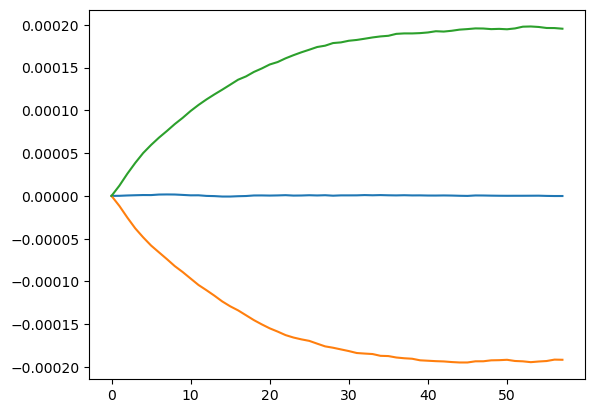

In [23]:
percentiles = np.percentile(out1, [50, 16, 84], axis=1)
plt.plot(percentiles.T)

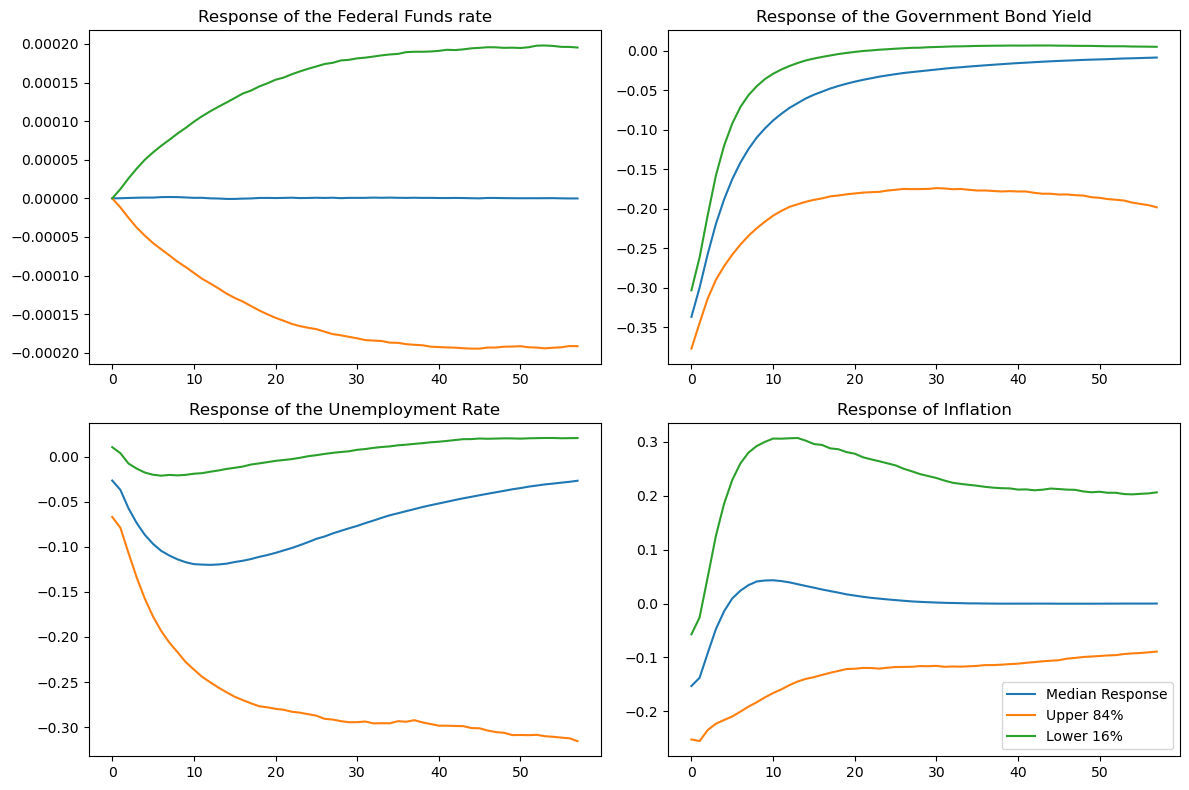

In [24]:
# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
percentiles = np.percentile(out1, [50, 16, 84], axis=1)
#plt.plot(np.hstack([percentiles, np.zeros((percentiles.shape[0], 1))]))
plt.plot(percentiles.T)
plt.title('Response of the Federal Funds rate')
plt.tight_layout()

plt.subplot(2, 2, 2)
percentiles = np.percentile(out2, [50, 16, 84], axis=1)
#plt.plot(np.hstack([percentiles, np.zeros((percentiles.shape[0], 1))]))
plt.plot(percentiles.T)
plt.title('Response of the Government Bond Yield')
plt.tight_layout()

plt.subplot(2, 2, 3)
percentiles = np.percentile(out3, [50, 16, 84], axis=1)
#plt.plot(np.hstack([percentiles, np.zeros((percentiles.shape[0], 1))]))
plt.plot(percentiles.T)
plt.title('Response of the Unemployment Rate')
plt.tight_layout()

plt.subplot(2, 2, 4)
percentiles = np.percentile(out4, [50, 16, 84], axis=1)
#plt.plot(np.hstack([percentiles, np.zeros((percentiles.shape[0], 1))]))
plt.plot(percentiles.T)
plt.title('Response of Inflation')
plt.tight_layout()

plt.legend(['Median Response', 'Upper 84%', 'Lower 16%', 'Zero Line'])
plt.show()